<a href="https://colab.research.google.com/github/joshbrx/biomath_model/blob/main/full_GRN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Full GRN in pancreas model for stellate cells and cancer cells.

Para modelar correctamente la red de regulación genética, renormbraremos las variables del sistema para poder simplificar el proceso

| $TNF_a$ | $TGFb_1$ | $RAS$ | $P53_s$ | $PIP3_s$ | $ERK_s$| $P53_c$ | $PIP3_c$ | $BCL-XL_c$ | $P21_c$ | $Apop_s$ | $Prolif_s$ | $Apop_c$ | $Prolif_c$ |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|$X_1$|$X_2$|$Y_1$|$Y_2$|$Y_3$|$Y_4$|$S_2$|$S_3$|$S_4$|$S_5$|$Z_1$|$Z_2$|$Z_3$|$Z_4$|

Considerando los tiempos de duración obtenidos para PanIN en el artículo: [Progression to pancreatic ductal adenocarcinoma from pancreatic intraepithelial neoplasia: Results of a simulation model](https://www.sciencedirect.com/science/article/pii/S1424390318306367?via%3Dihub), se tiene lo siguiente:

| **_Etapas_** 	| **_Todas las mujeres_** 	| **_Mujeres que pasan <br>a la siguiente etapa_** 	| **_Todos los hombres_** 	| **_Hombres que pasan <br>a la siguiente etapa_** 	|
|:---:	|:---:	|:---:	|:---:	|:---:	|
| Tiempo en PanIN 1<br>Años promedio <br>(IQR Q1-Q3) 	| 23.7<br>(10.3–34.9) 	| 17.4<br>(6.50–25.6) 	| 22.3<br>(9.42–32.8) 	| 16.5<br>(6.00–24.3) 	|
| Tiempo en PanIN 2<br>Años promedio <br>(IQR Q1-Q3) 	| 17.5<br>(6.50–25.7) 	| 13.9<br>(4.83–20.3) 	| 16.4<br>(6.00–24.1) 	| 13.3<br>(4.58–19.3) 	|
| Tiempo en PanIN 3<br>Años promedio <br>(IQR Q1-Q3) 	| 11.3<br>(3.75–16.3) 	| 10.0<br>(3.25–14.3) 	| 10.0<br>(3.25–14.3) 	| 9.0<br>(2.83–12.8) 	|
| Tiempo en PDAC no-detectado<br>Años promedio <br>(IQR Q1-Q3) 	|  	| 2.65<br>(1.00–3.58) 	|  	| 2.56<br>(0.92–3.50) 	|
| PanIN 1 a PDAC detectado<br>Años promedio<br>(IQR Q1-Q3) 	|  	| 35.3<br>(25.6–44.7) 	|  	| 33.6<br>(24.0–42.6) 	|
| PanIN 3 a PDAC detectado<br>Años promedio <br>(IQR Q1-Q3) 	|  	| 12.3<br>(5.75–16.8) 	|  	| 11.3<br>(5.25–15.4) 	|

Por lo que si consideramos $\tau_1$ y $\tau_2$ como directamente proporcinales al tiempo de transición de sano a PanIN 1 y al tiempo de transición de PanIN 1 a PanIN 2, respectivamente, entonces podemos decir que $\tau_1>\tau_2$.

\begin{align*}
    k_{1\to 2,H} = \frac{\tau_{2,H}}{\tau_{1,H}} = \frac{13.9\ \text{años}}{17.4\ \text{años}} = 0.798\qquad \text{(En hombres)} \\
    k_{1\to 2,M} = \frac{\tau_{2,M}}{\tau_{1,M}} = \frac{13.3\ \text{años}}{16.5\ \text{años}} = 0.807\qquad \text{(En mujeres)}
\end{align*}

Por lo que se puede considerar que constante de proporcionalidad es $k_{1\to 2} = 0.8$ en el caso general.

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import random 
from scipy import signal
from ipywidgets import interact
import ipywidgets as widgets
%matplotlib inline

In [2]:
def supr(e, n, s):
    return e/(1 + s**n)

In [3]:
def plot_supr(n):
    x = np.linspace(0.01, 2*np.pi, 2000)
    y = supr(1, n, x)
    plt.plot(x, y); plt.grid(); plt.show()

interact(plot_supr, n = widgets.FloatSlider(value=9.5, min=-10, max=10, step=1))

interactive(children=(FloatSlider(value=9.5, description='n', max=10.0, min=-10.0, step=1.0), Output()), _dom_…

<function __main__.plot_supr(n)>

In [4]:
def dS(S, i, y1_tau1, c3_tau2, X1, X2):
    y1, y2, y3, y4, c2, c3, c4, c5, z1, z2, z3, z4, Ry1, Ry2, Ry3, Ry4, Rc2, Rc3, Rc4, Rc5, Rz1, Rz2, Rz3, Rz4, Rc2a, Rc2b, c2a, c2b = S
    # --------------------------------------------------------
    dRy1 = e[0]*(supr(1, n[0], X1[i]) + supr(1, n[0], y1_tau1) + supr(1, n[0], y3) + supr(1, n[0], y4)) - Ry1;    
    # dRy1 = e[0]*(supr(1, n[0], X1[i]) + supr(1, n[0], y1_tau1) + supr(1, n[0], y3) + supr(1, n[0], y4) + supr(c, n[0], c3_tau2)) - Ry1;    
    dy1  = supr(1, n[1], Ry1) - y1;         # 1/0.4

    dRy2 = e[1]*(supr(1, n[0], y1) + (supr(1, -n[0], y2) * supr(1, -n[0], y3))) - Ry2
    dy2  = supr(1, n[1], Ry2) - y2;         # 1/2.14 o 1/2.1

    dRy3 = e[2]*(supr(1, n[0], X2[i]) + supr(1, n[0], y1) + supr(1, -n[0], y2)) - Ry3         
    dy3  = supr(1, n[1], Ry3) - y3;         # 1/2.14

    dRy4 = e[3]*(supr(1, n[0], X2[i]) + supr(1, n[0], y1)) - Ry4;
    dy4  = supr(1, n[1], Ry4) - y4;         # 1/0.35
    # --------------------------------------------------------
    # dRz1 = dRy2; dz1  = dy2;
    dRz2 = e[4]*(supr(1, -n[0], y2) + supr(1, n[0], y4)) - Rz2
    dz2  = supr(1, n[1], Rz2) - z2;         # 1/1.15
    # --------------------------------------------------------
    dRc2a = e[5]*(supr(2, -n[0], c2) + supr(2, -n[0], c3)) - Rc2a
    dc2a  = supr(1, n[1], Rc2a) - c2a;
    dRc2b = e[6]*(supr(2, +n[0], c2) + supr(2, -n[0], c3)) - Rc2b
    dc2b  = supr(1, n[1], Rc2b) - c2b;
    dRc2 = e[7]*(supr(2, +n[0], c2) + supr(2, -n[0], c3)) - Rc2
    dc2  = supr(1, n[1], Rc2) - c2;

    dRc3 = e[8]*(supr(1, n[0], y1_tau1) + supr(1, -n[0], c2)) - Rc3
    dc3  = supr(1, n[1], Rc3) - c3;

    dRc4 = e[9]*(supr(1, n[0], y1_tau1) + supr(1, n[0], c3) + supr(2, -n[0], c2)) - Rc4
    dc4  = supr(1, n[1], Rc4) - c4;

    dRc5 = e[10]*(supr(1, n[0], X2[i]) + supr(1, n[0], c2)) - Rc5
    dc5  = supr(1, n[1], Rc5) - c5;
    # --------------------------------------------------------
    dRz3 = e[11]*(supr(2, -n[0], c3) + supr(1, n[0], c2) + supr(1, -n[0], c4)) - Rz3
    dz3  = supr(1, n[1], Rz3) - z3;

    dRz4 = e[12]*(supr(1, n[0], y1_tau1) + supr(1, n[0], c3_tau2) + supr(1, -n[0], c5)) - Rz4
    dz4  = supr(1, n[1], Rz4) - z4;
    # --------------------------------------------------------
    dS = [dy1, dy2, dy3, dy4, dc2, dc3, dc4, dc5, dy2, dz2, dz3, dz4, dRy1, dRy2, dRy3, dRy4, dRc2, dRc3, dRc4, dRc5, dRy2, dRz2, dRz3, dRz4, dRc2a, dRc2b, dc2a, dc2b]
    return np.array(dS)

In [19]:
def RK_solver(S0, t, tau, k, X1, X2):
    dims = len(S0)
    K = np.empty([4, dims])
    S = np.zeros([len(t)+1, dims])
    
    for d in range(dims):   
        S[0, d] = S0[d]

    dt = t[1] - t[0]; 
    for i in range(len(t)):
        y1_tau1, c3_tau2 = S[i-int(tau), 0], S[i-int(tau*(1+k)), 5]
        K[0] = dt * dS(S[i]         , i, y1_tau1, c3_tau2, X1, X2) 
        K[1] = dt * dS(S[i] + K[0]/2, i, y1_tau1, c3_tau2, X1, X2)
        K[2] = dt * dS(S[i] + K[1]/2, i, y1_tau1, c3_tau2, X1, X2)
        K[3] = dt * dS(S[i] + K[2]  , i, y1_tau1, c3_tau2, X1, X2)
        for d in range(dims):
            S[i+1, d] = S[i, d] + (K[0,d]+2*K[1,d]+2*K[2,d]+K[3,d])/6
    return S

In [143]:
# parámetros
n = [-4, -20] 
e = [1/0.4, 1/1.2, 1/2.14, 1/0.35, 1/1.15, 1/1.4, 1, 1/0.2, 2.5, 1/1.25, 1/4.25, 1/2.75, 1/1.75]
start=0; step=0.1; num=20000
t = np.arange(0.001, num)*step + start

S0 = np.concatenate([np.array([0, 0, 1, 1]), np.zeros(24)])   # Y, C, Z, R

In [164]:
labels = ["$RAS$","$P53_s$","$PIP3_s$","$ERK_s$","$P53_c$","$PIP3_c$","$BCL-XL$","$P21_c$","$Apop_s$","$Prolif_s$","$Apop_c$","$Prolif_c$"]

def plot_full_GRN(omega, tau, k, n_exp):
    X1, X2 = (0.5*(np.sin(t/omega)+1))**n_exp, (0.5*(np.cos(t/omega)+1))**n_exp
    # X1 = (1 + signal.square(2 * np.pi * t / omega, duty=0.1))*0.5; 
    # X2 = (1 - signal.square(2 * np.pi * t / omega, duty=1-0.1))*0.5 
    # X1, X2 = np.sin(t*omega)**n_exp, np.cos(t*omega)**n_exp
    Pip = RK_solver(S0, t, tau, k, X1, X2)
    fig = plt.figure(figsize=(12,4.5), dpi=100); gs = fig.add_gridspec(3, hspace=0.05)
    axs = gs.subplots(sharex=True)
    for i in range(4):
        axs[0].plot(t, Pip[1:,i]  , label=labels[i])
        axs[1].plot(t, Pip[1:,i+4], label=labels[i+4])
        axs[2].plot(t, Pip[1:,i+8], label=labels[i+8])
    axs[0].legend(); axs[0].grid(); axs[0].set_xlim([t[0], t[-1]]); # axs[0].set_ylim([0, 5])
    axs[1].legend(); axs[1].grid(); axs[1].set_xlim([t[0], t[-1]]); # axs[1].set_ylim([0, 1])
    axs[2].legend(); axs[2].grid(); axs[2].set_xlim([t[0], t[-1]]); # axs[2].set_ylim([0, 0.29])
    fig.suptitle(f"Full GRN in pancreas, $\omega=${omega}, $τ_1=${int(tau)*step}, $τ_2=${int(tau*(1+k))*step}"); plt.show()

In [165]:
interact(plot_full_GRN, omega = widgets.FloatSlider(value=1.95, min=0.1, max=10, step=0.01),
                          tau = widgets.FloatSlider(value=2942, min=1000, max=4000, step=1),
                            k = widgets.FloatSlider(value=0.80, min=0.10, max=2.00, step=0.01),
                        n_exp = widgets.FloatSlider(value=2, min=-10, max=12, step=2))

interactive(children=(FloatSlider(value=1.95, description='omega', max=10.0, min=0.1, step=0.01), FloatSlider(…

<function __main__.plot_full_GRN(omega, tau, k, n_exp)>

<ipython-input-2-c9dcc9093113>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return e/(1 + s**n)


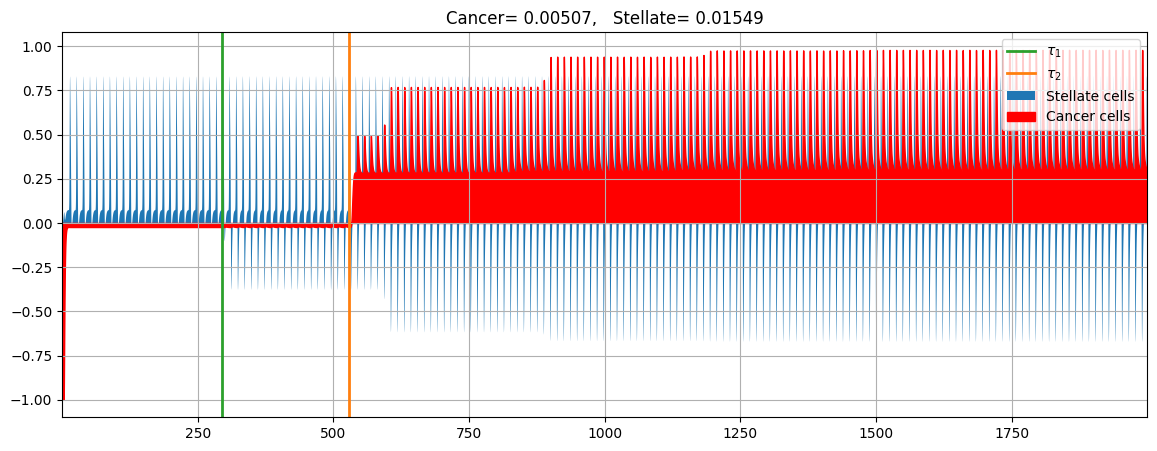

0.04794912343623505 0.09525195221965363


In [124]:
omega, tau, k, n_exp= 1.95, 2942, 0.8, 2
# omega, tau, k, n_exp= 3.9, 1478, 0.8, 2
# X1, X2 = np.sin(t/omega)**n_exp, np.cos(t/omega)**n_exp
X1, X2 = (0.5*(np.sin(t/omega)+1))**n_exp, (0.5*(np.cos(t/omega)+1))**n_exp
Pip = RK_solver(S0, t, tau, k, X1, X2)
A = np.array([np.max(Pip[:,8]), np.max(Pip[:,9]), np.max(Pip[:,10]), np.max(Pip[:,11])]);

plt.figure(figsize=(14,5), dpi=100)
plt.axvline(x=tau/10, lw=2, color="tab:green", label="$τ_1$"); plt.axvline(x=tau*(1+k)/10, lw=2, color="tab:orange", label="$τ_2$");
plt.fill_between(t, -Pip[1:,8] /A[0] + Pip[1:,9] /A[1], label="Stellate cells")
plt.fill_between(t, -Pip[1:,10]/A[2] + Pip[1:,11]/A[3], label="Cancer cells", color="red")

plt.grid(); plt.legend(); plt.xlim([t[0], t[-1]]);
plt.title(f"Cancer= {round(np.mean(A[3]*Pip[:,11]), 5)},   Stellate= {round(np.mean(-A[0]*Pip[:,8] + A[1]*Pip[:,9]), 5)}"); plt.show()
print(np.mean(Pip[1600:,8]), np.mean(Pip[1600:,9]))

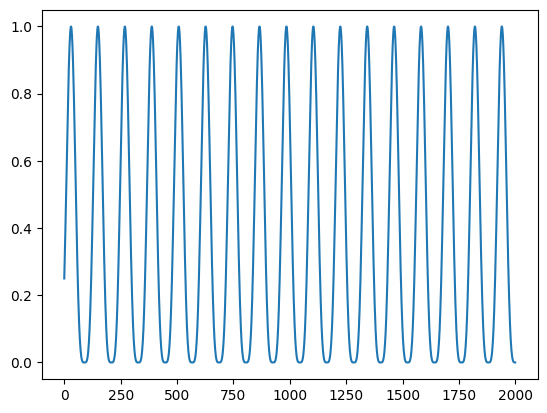

In [110]:
plt.plot()